20200803_02

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Objectives
- We would like to verify if a grism from drz-blot flt frame is different to that of original flt frame.
- If there is difference, 
 - how much is the difference quantitatively?
 - can we compute the correction values?
 
# Previously...
- 20200731 identified 5 stars in the field. S03 was selected. Flatfielded flt images were done (./rootname_S03/rootname_flt.fits), and they were drizzled and blotted back (./drzblot_S03/idlk01jmq_flt.fits). Code check is required.
- 20200803_01 continued, but faced problem of background subtraction that we would like to avoid.
 
# Tasks
Similarly try the same process with GD153.
 

In [11]:
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob,copy,os


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [12]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG102(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))


# 1. Generate flatfielded flt

In [13]:
filelist = glob.glob('/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/*/*flt.fits')
for i,ii in enumerate(filelist):
    h = fits.open(ii)[0].header
    print(i,h['FILTER'],h['ROOTNAME'],h['POSTARG1'],h['POSTARG2'])


0 G102 iab901enq -21.200001 1.2
1 G102 iab901emq -21.0 1.0
2 F105W iab901erq 23.0 -45.0
3 F098M iab901eqq 23.0 -45.0
4 F098M iab901eiq -20.0 0.0
5 F105W iab9a1exq -50.0 45.0
6 F105W iab901ejq -20.0 0.0
7 G102 iab901ekq -20.0 0.0
8 G102 iab9a1eyq -50.0 45.0
9 G102 iab901esq 23.0 -45.0
10 F098M iab9a1ewq -50.0 45.0
11 G102 iab901elq -20.5 0.5


Save ./iab901ekq_GD153/iab901ekq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901ekq_GD153/iab901ekq_GD153_trace.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_overview.pdf

Save ./iab901ekq_GD153/iab901ekq_GD153_tbox.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_bbox.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_bbcorner.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_cutout.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_fullflat.fits
Update flatfielded ./iab901ekq_GD153/iab901ekq_flt.fits
Save ./iab901elq_GD153/iab901elq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901elq_GD153/iab901elq_GD153_trace.csv
Save ./iab901elq_GD153/iab901elq_GD153_overview.pdf

Save ./iab901elq_GD153/iab901elq_GD153_tbox.csv
Save ./iab901elq_GD153/iab901elq_GD15

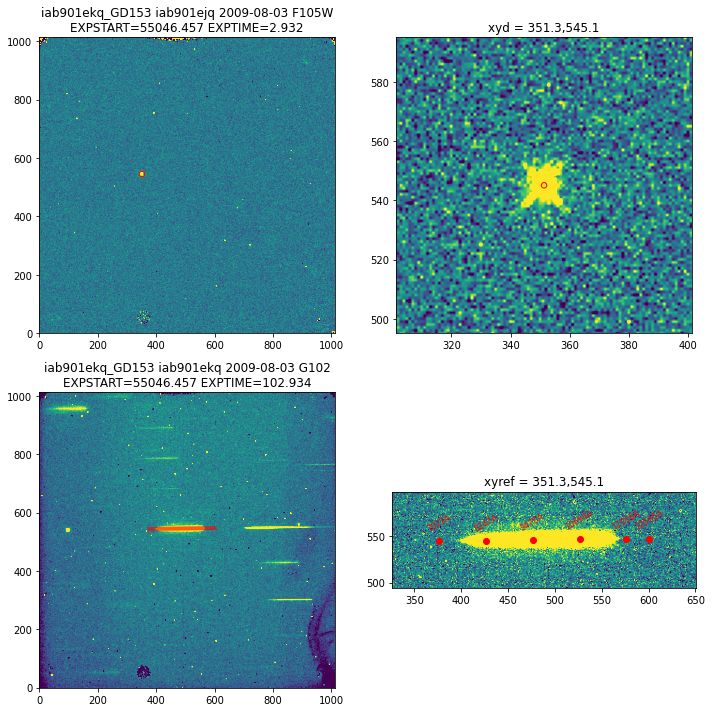

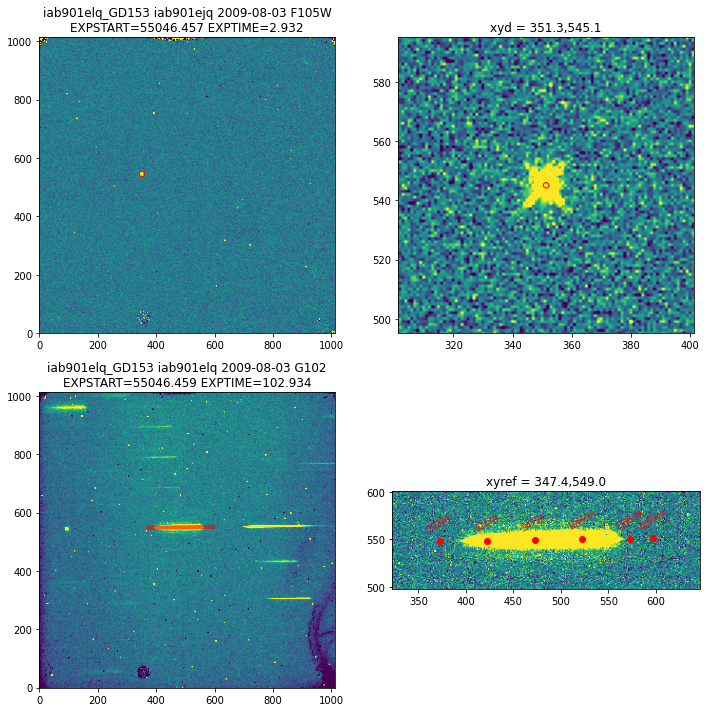

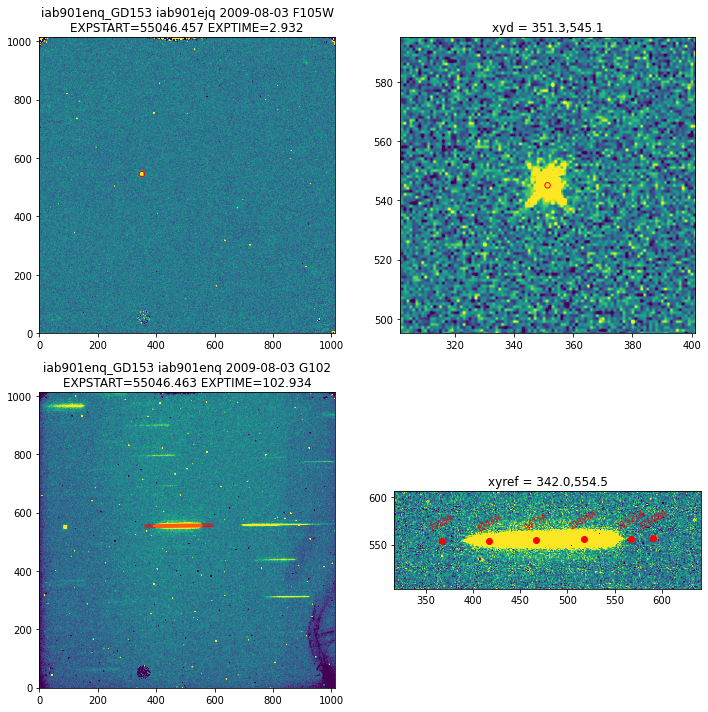

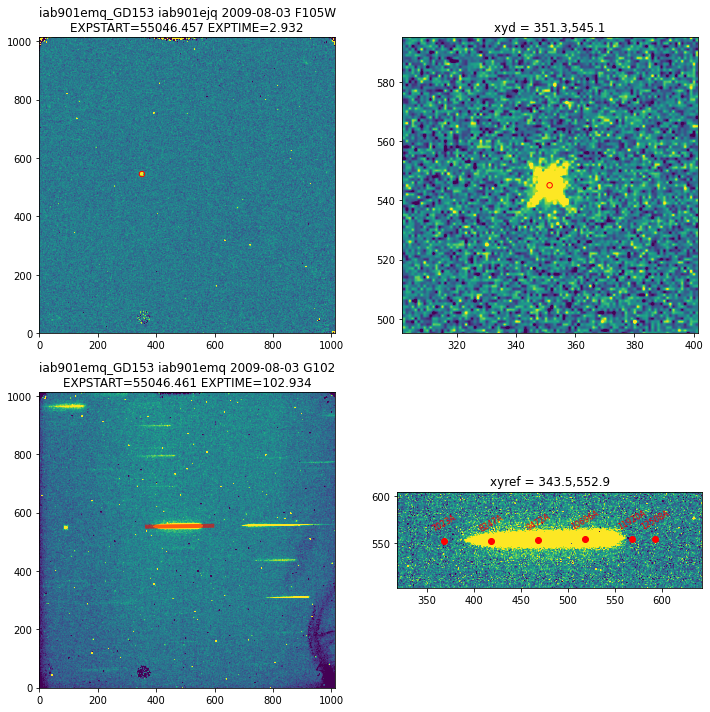

In [14]:
# F105W: 6
# G102: 7,11,0,1
# We choose this set because of 4-point dither in the central region
for i in [7,11,0,1]:
    dfile = (filelist[6],1)
    gfile = (filelist[i],1)
    rootname = fits.open(gfile[0])[0].header['ROOTNAME']
    sourcename = 'GD153'
    saveprefix = '{0}_{1}'.format(rootname,sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    xyd = (351.32706,545.13459)
    beam = 'A'
    confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
    flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
    params_overview = {'figsize': (10, 10), 
                       '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                       '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                       '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                       '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
    generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                               xyd,confile,beam,gfile,dfile,
                               flatfile,
                           params_overview
                              )


# 2. Generate drzblot

In [16]:
# make drzlist
drzlist = []
sourcename = 'GD153'
for i in [7,11,0,1]:
    tmp = filelist[i].split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,sourcename,tmp)
    drzlist.append(string)
drzlist


['./iab901ekq_GD153/iab901ekq_flt.fits',
 './iab901elq_GD153/iab901elq_flt.fits',
 './iab901enq_GD153/iab901enq_flt.fits',
 './iab901emq_GD153/iab901emq_flt.fits']

In [17]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':False,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
          'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':False,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0],
              
         }
AstroDrizzle(input=drzlist,output=sourcename,**params_drz)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13:15:12.23 (03/08/2020)

==== Processing Step  Initialization  started at  13:15:12.240 (03/08/2020)

Creating OUTPUT WCS from ./iab901ekq_GD153/iab901ekq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.9586534100876e-05 -2.0839609710612e-05
CD_21  CD_22: -2.3232847881681e-05 2.63567592329992e-05
CRVAL    : 194.2555960240834 22.02615138481296
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542548409184785
ORIENTAT : -38.332512773224956
********************************************************************************
*
*  Estimated memory usage:  up to 78 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 13:15:12.870 (03/08/2020)
==== Processing Step  Static Mask  started at 

Writing out image to disk: /Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901emq_GD153/iab901emq_sci1_blt.fits
==== Processing Step Blot finished at 13:15:20.729 (03/08/2020)
==== Processing Step  Driz_CR  started at  13:15:20.730 (03/08/2020)

Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901elq_GD153/iab901elq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901enq_GD153/iab901enq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901emq_GD153/iab901emq_sci1_crmask.fits
==== Processing Step Driz_CR finished at 13:15:21.85 (03/08/2020)
==== Processing Step  Final Drizzle  started at  13:15:21.862 (03/08/2020)

WCS Keywords

CD_11  CD_12: -2.9586534100876e-05 -2.0839609710612e-05
CD_21  CD_22: -2.3232847881681e-05 2.63567592329992e-05
CRVAL    : 194.2555960240834 22.02615138481296
CRPIX    : 507

In [18]:
# setup
drzfile = glob.glob('*drz.fits')[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname,sourcename = reffile.split('/')[1].split('_')
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(sourcename,rootname)
drzfile,reffile,skyval,outdata

('GD153_drz.fits',
 './iab901ekq_GD153/iab901ekq_flt.fits',
 1.350065350532532,
 './drzblot_GD153/iab901ekq_drzblot_sci.fits')

In [21]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(sourcename)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(filelist[7],savefolder))
string = './{0}/{1}'.format(savefolder,filelist[7].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Using coordinate transformation defined by user...
Added 1.350065350532532 counts back in to blotted image as sky.
Created output image: ./drzblot_GD153/iab901ekq_drzblot_sci.fits


# 3. Check

In [42]:
origfltfile = ('/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901ekq/iab901ekq_flt.fits',1)
flatfltfile = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_flt.fits',1)
drzblotfile = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/iab901ekq_flt.fits',1)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


The right plot shows the ratio of origflt/flatflt.
It shows flatfield image as expected.


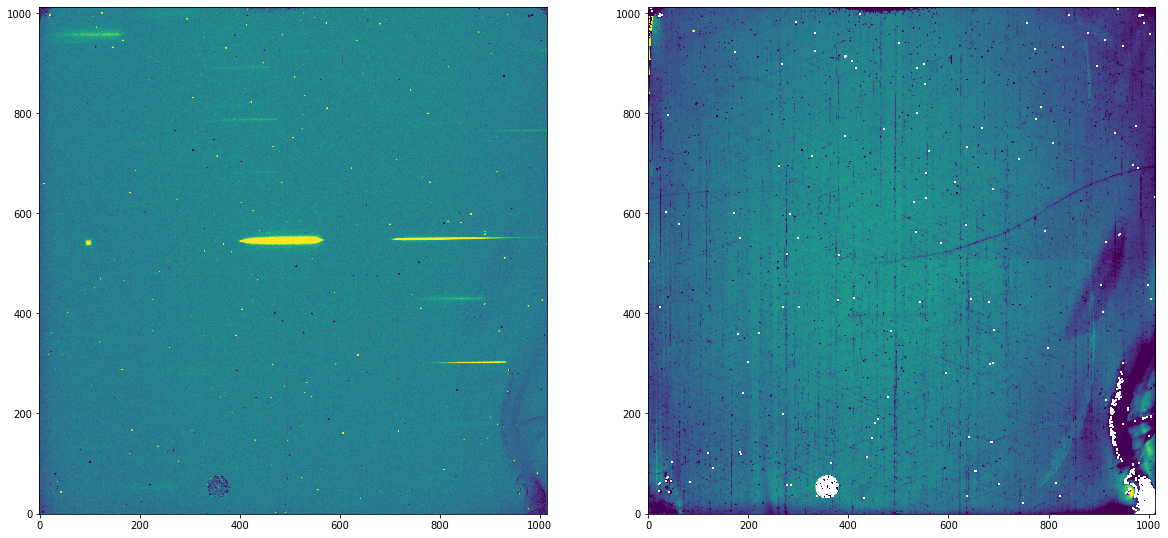

In [65]:
a,b = origfltfile,flatfltfile
ad = fits.open(a[0])[a[1]].data
bd = fits.open(b[0])[b[1]].data
fig = plt.figure(figsize = (20,10))
ax121 = fig.add_subplot(1,2,1)
ax121.imshow(ad,origin='lower',vmin=0.,vmax=3.)
ax122 = fig.add_subplot(1,2,2)
ax122.imshow(ad/bd,origin='lower',vmin=0.9,vmax=1.1)
print('The right plot shows the ratio of origflt/flatflt.')
print('It shows flatfield image as expected.')


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


The right plot shows the ratio of drzblot/flatflt.
The line structure implies that drzblot has wider line spread as expected.


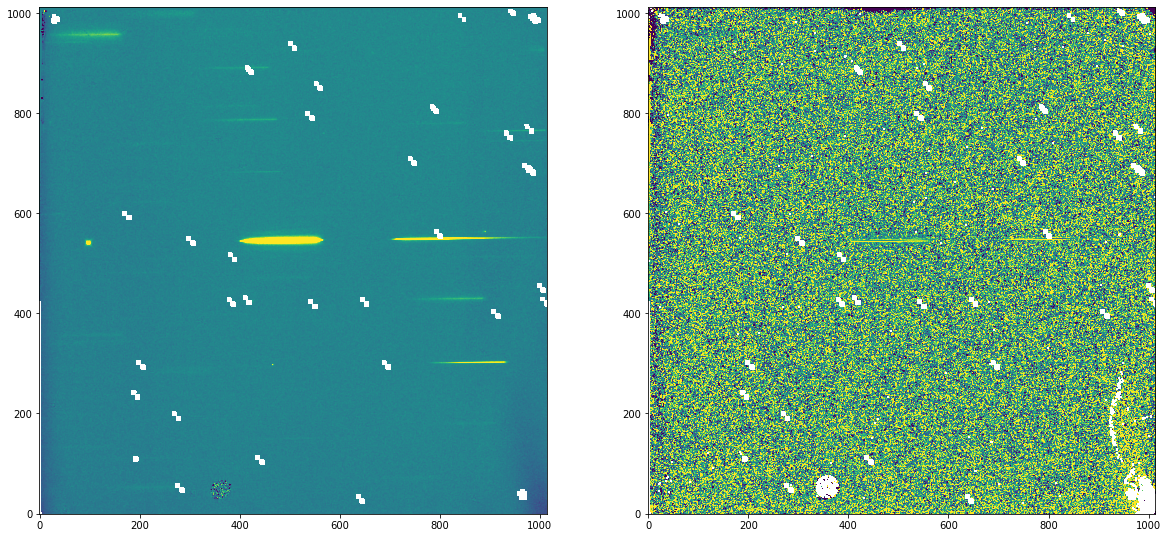

In [46]:
a,b = drzblotfile,flatfltfile
ad = fits.open(a[0])[a[1]].data
bd = fits.open(b[0])[b[1]].data
fig = plt.figure(figsize = (20,10))
ax121 = fig.add_subplot(1,2,1)
ax121.imshow(ad,origin='lower',vmin=0.,vmax=3.)
ax122 = fig.add_subplot(1,2,2)
ax122.imshow(ad/bd,origin='lower',vmin=0.9,vmax=1.1)
print('The right plot shows the ratio of drzblot/flatflt.')
print('The line structure implies that drzblot has wider line spread as expected.')


# 4. Make cutout

## 4.1. drzblot

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./drzblot_GD153/drzblot_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./drzblot_GD153/drzblot_trace.csv
Save ./drzblot_GD153/drzblot_overview.pdf



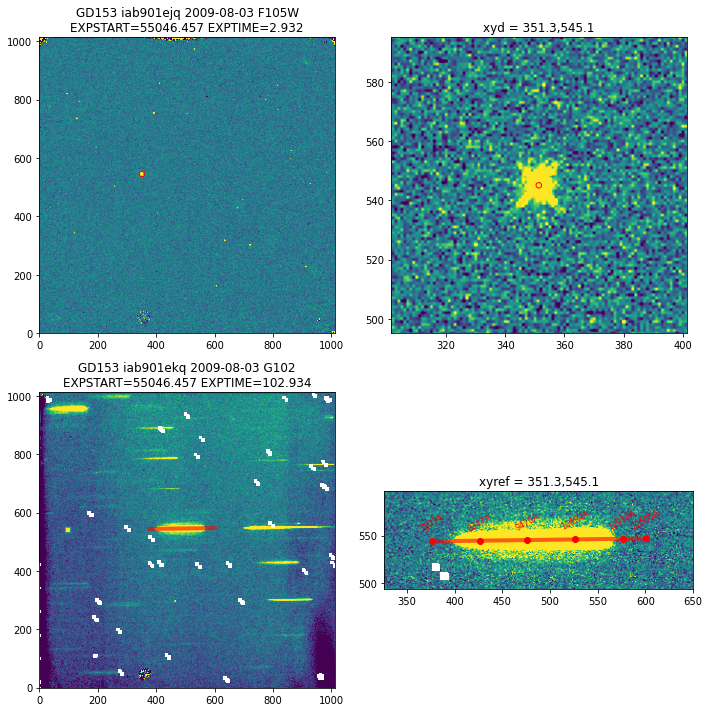

In [122]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy
##########
# Make Container
##########
saveprefix = 'drzblot'
savefolder = 'drzblot_GD153'
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)
##########
# Compute xyref
##########
xyd = (351.32706,545.13459)
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
beam = 'A'
gfile = drzblotfile
dfile = (filelist[6],1)
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG102(**grism_params)
grismobj.compute()
grismobj.save()
##########
# show_overview
##########
show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
              objname='GD153',
              save=True,
              container=containerobj,
             )


Save ./drzblot_GD153/drzblot_tbox.csv
Save ./drzblot_GD153/drzblot_bbox.csv
Save ./drzblot_GD153/drzblot_bbcorner.csv
Save ./drzblot_GD153/drzblot_cutout.fits
Save ./drzblot_GD153/drzblot_mask.fits
Save ./drzblot_GD153/drzblot_bbox.pdf


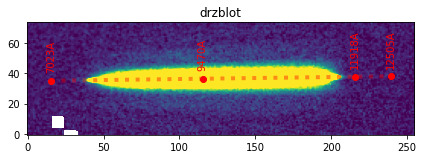

In [123]:
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
halfdy = 20
tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_bbox
##########
show_bbox(cutoutdata=cutoutobj.cutout,
          objname='drzblot',
#           maskdata=cutoutobj.mask,
          maskdata=None,
          do_trace=True,
          xcut=xg - cutoutobj.bbcorner['bb0x'],
          ycut=yg - cutoutobj.bbcorner['bb0y'],
          ww=tdata.ww,
          save=True,container=containerobj
         )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,73.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 71 invalid data points
data_minmax = (1.0715452432632446,159.23306274414062) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./drzblot_GD153/drzblot_cutbkg.fits
Save ./drzblot_GD153/drzblot_maskfit.fits


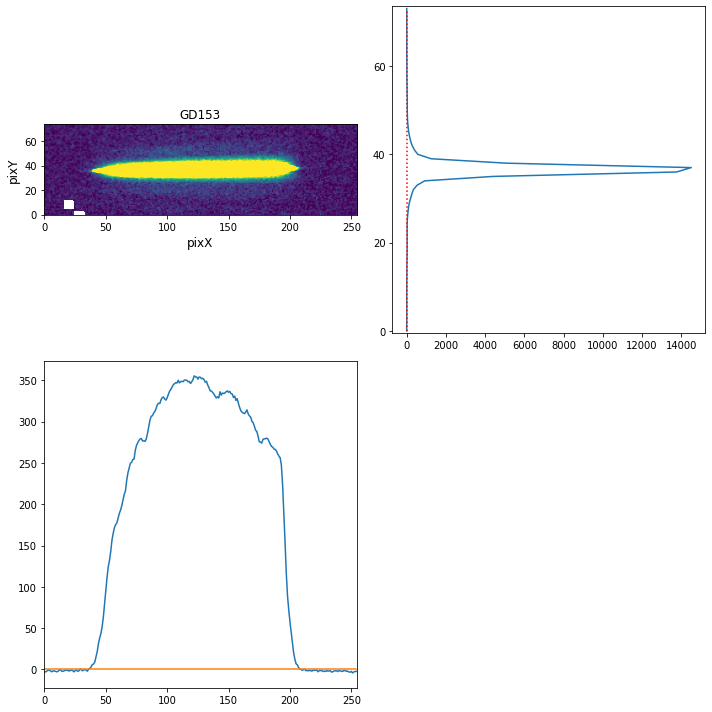

In [126]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data 
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 0
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# show_sum1d
##########
tmpdata = gdata - bkgobj.poly2d.model['YFIT']
show_sum1d(gdata=tmpdata,
           objname='GD153',
           mdata=None,
           do_zero=True,
           save=False,container=None)



In [151]:
print('The sum1d plots show the quality of background subtraction is good.')
print('Note that we apply a flat background which is simple and should not correlate with what we are doing here, unlike using higher-order background.')


The sum1d plots show the quality of background subtraction is good.
Note that we apply a flat background which is simple and should not correlate with what we are doing here, unlike using higher-order background.


## 4.2. flatflt

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901ekq_GD153/iab901ekq_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901ekq_GD153/iab901ekq_trace.csv
Save ./iab901ekq_GD153/iab901ekq_overview.pdf



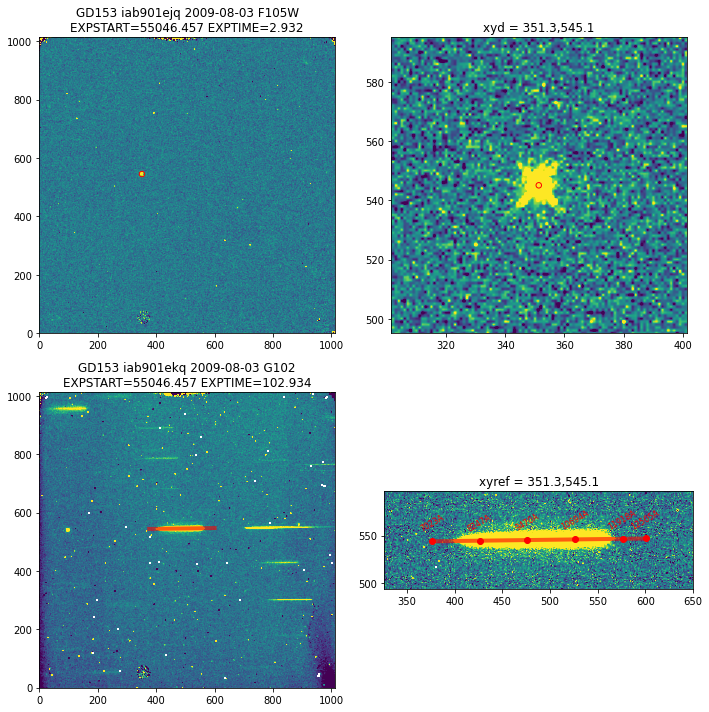

In [127]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy
##########
# Make Container
##########
saveprefix = 'iab901ekq'
savefolder = 'iab901ekq_GD153'
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)
##########
# Compute xyref
##########
xyd = (351.32706,545.13459)
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
beam = 'A'
gfile = flatfltfile
dfile = (filelist[6],1)
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG102(**grism_params)
grismobj.compute()
grismobj.save()
##########
# show_overview
##########
show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
              objname='GD153',
              save=True,
              container=containerobj,
             )


Save ./iab901ekq_GD153/iab901ekq_tbox.csv
Save ./iab901ekq_GD153/iab901ekq_bbox.csv
Save ./iab901ekq_GD153/iab901ekq_bbcorner.csv
Save ./iab901ekq_GD153/iab901ekq_cutout.fits
Save ./iab901ekq_GD153/iab901ekq_mask.fits
Save ./iab901ekq_GD153/iab901ekq_bbox.pdf


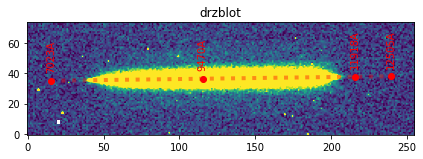

In [128]:
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
halfdy = 20
tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_bbox
##########
show_bbox(cutoutdata=cutoutobj.cutout,
          objname='drzblot',
#           maskdata=cutoutobj.mask,
          maskdata=None,
          do_trace=True,
          xcut=xg - cutoutobj.bbcorner['bb0x'],
          ycut=yg - cutoutobj.bbcorner['bb0y'],
          ww=tdata.ww,
          save=True,container=containerobj
         )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,73.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 1 invalid data points
data_minmax = (-1.7574290037155151,187.76333618164062) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab901ekq_GD153/iab901ekq_cutbkg.fits
Save ./iab901ekq_GD153/iab901ekq_maskfit.fits


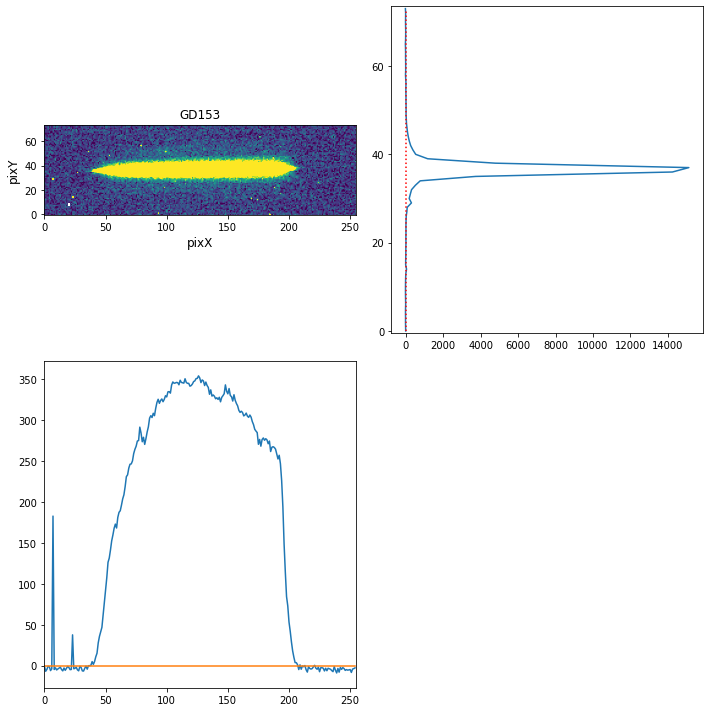

In [129]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data 
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 0
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# show_sum1d
##########
tmpdata = gdata - bkgobj.poly2d.model['YFIT']
show_sum1d(gdata=tmpdata,
           objname='GD153',
           mdata=None,
           do_zero=True,
           save=False,container=None)



In [152]:
print('The sum1d plots show the quality of background subtraction is good.')
print('Note that we apply a flat background which is simple and should not correlate with what we are doing here, unlike using higher-order background.')


The sum1d plots show the quality of background subtraction is good.
Note that we apply a flat background which is simple and should not correlate with what we are doing here, unlike using higher-order background.


## 4.3. Check bkg

In [140]:
drzblotbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutbkg.fits',1)
flatfltbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutbkg.fits',1)
a = fits.open(drzblotbkg[0])[drzblotbkg[1]].data
b = fits.open(flatfltbkg[0])[flatfltbkg[1]].data
print(a.mean(),b.mean())
print('This shows the background levels from both drzblot and flatflt to be about the same.')

1.404923726473612 1.433656947765087
This shows the background levels from both drzblot and flatflt to be about the same.


This shows that background region of drzblot is slight brighter.


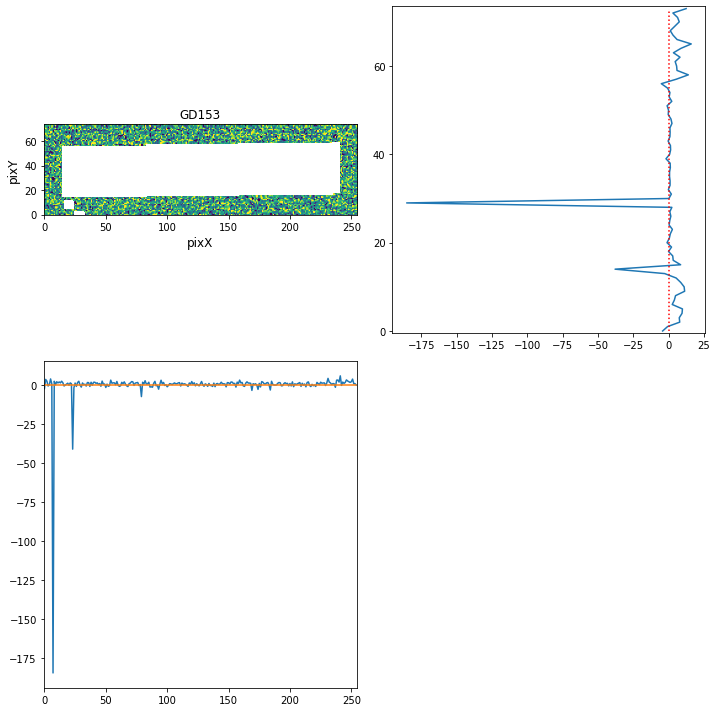

In [142]:
drzblotcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutout.fits',1)
drzblotbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutbkg.fits',1)
flatfltcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutout.fits',1)
flatfltbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutbkg.fits',1)
mask = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_mask.fits',1)
a,b,a_bkg,b_bkg = drzblotcut,flatfltcut,drzblotbkg,flatfltbkg
ad,ad_bkg = fits.open(a[0])[a[1]].data,fits.open(a_bkg[0])[a_bkg[1]].data
bd,bd_bkg = fits.open(b[0])[b[1]].data,fits.open(b_bkg[0])[b_bkg[1]].data
ad,bd = ad-ad_bkg,bd-bd_bkg
tmpdata = ad - bd
mdata = fits.open(mask[0])[mask[1]].data.astype(bool)
show_sum1d(gdata=tmpdata,
           objname='GD153',
           mdata=mdata,
           do_zero=True,
           save=False,container=None)
print('This shows that background region of drzblot is slight brighter.')


This shows that applying flatflt"s bkg to drzblot sets the background region of drzblot to be at the same level.


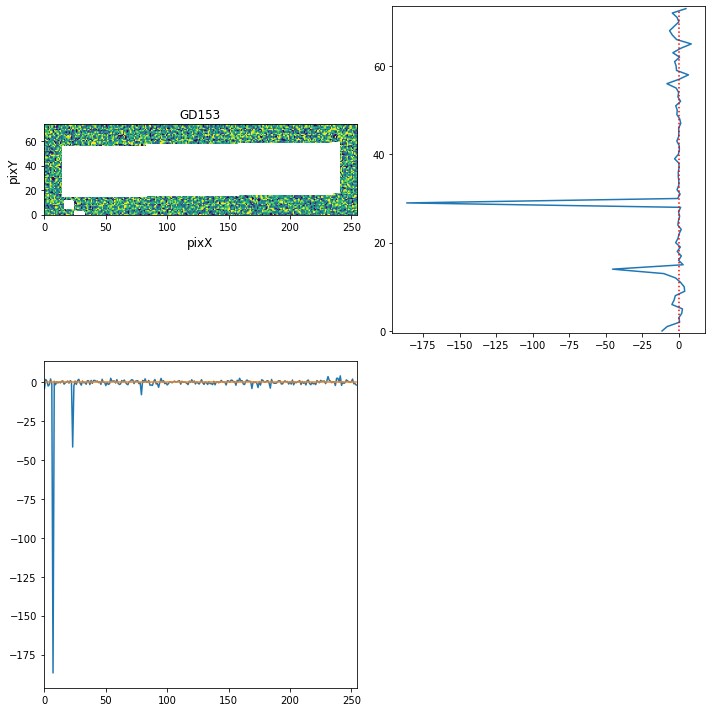

In [147]:
drzblotcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutout.fits',1)
drzblotbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutbkg.fits',1)
flatfltcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutout.fits',1)
flatfltbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutbkg.fits',1)
mask = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_mask.fits',1)
a,b,a_bkg,b_bkg = drzblotcut,flatfltcut,drzblotbkg,flatfltbkg
ad,ad_bkg = fits.open(a[0])[a[1]].data,fits.open(a_bkg[0])[a_bkg[1]].data
bd,bd_bkg = fits.open(b[0])[b[1]].data,fits.open(b_bkg[0])[b_bkg[1]].data
ad,bd = ad-bd_bkg,bd-bd_bkg
tmpdata = ad - bd
mdata = fits.open(mask[0])[mask[1]].data.astype(bool)
show_sum1d(gdata=tmpdata,
           objname='GD153',
           mdata=mdata,
           do_zero=True,
           save=False,container=None)
print('This shows that applying flatflt"s bkg to drzblot sets the background region of drzblot to be at the same level.')



# Note:
We will use flatflt's bkg with drzblog.

# 5. Preview

In [148]:
drzblotcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutout.fits',1)
drzblotbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_cutbkg.fits',1)
flatfltcut = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutout.fits',1)
flatfltbkg = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_cutbkg.fits',1)
mask = ('/Users/kbhirombhakdi/_work/Sidekicks/20200803/drzblot_GD153/drzblot_mask.fits',1)
tracefile = '/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_trace.csv'
bbcorner = '/Users/kbhirombhakdi/_work/Sidekicks/20200803/iab901ekq_GD153/iab901ekq_bbcorner.csv'


The bottom plot shows the ratio of drzblot/flatflt.
The line structure implies that drzblot has wider line spread as expected.


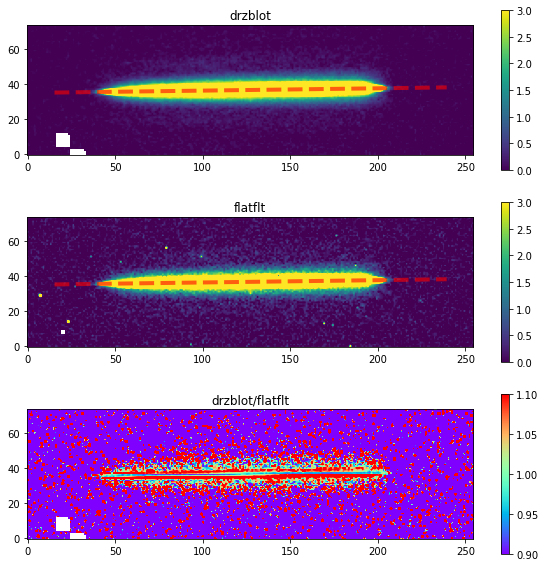

In [150]:
a,b,b_bkg = drzblotcut,flatfltcut,flatfltbkg
c,d = pd.read_csv(tracefile),pd.read_csv(bbcorner)
xcut = c.xh.values + c.xyref[0] - d.bb0x[0]
ycut = c.yh.values + c.xyref[1] - d.bb0y[0]
ad = fits.open(a[0])[a[1]].data
bd,bd_bkg = fits.open(b[0])[b[1]].data,fits.open(b_bkg[0])[b_bkg[1]].data
ad,bd = ad-bd_bkg,bd-bd_bkg
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(3,1,1)
im1 = ax1.imshow(ad,origin='lower',vmin=0.,vmax=3.)
ax1.plot(xcut,ycut,'r--',lw=4,alpha=0.6)
fig.colorbar(im1)
ax1.set_title('drzblot',fontsize=12)
ax2 = fig.add_subplot(3,1,2)
im2 = ax2.imshow(bd,origin='lower',vmin=0.,vmax=3.)
ax2.plot(xcut,ycut,'r--',lw=4,alpha=0.6)
fig.colorbar(im2)
ax2.set_title('flatflt',fontsize=12)
ax3 = fig.add_subplot(3,1,3)
im3 = ax3.imshow(ad/bd,origin='lower',cmap='rainbow',vmin=0.9,vmax=1.1)
# ax3.plot(xcut,ycut,'k:',lw=1,alpha=0.6)
fig.colorbar(im3)
ax3.set_title('drzblot/flatflt',fontsize=12)
print('The bottom plot shows the ratio of drzblot/flatflt.')
print('The line structure implies that drzblot has wider line spread as expected.')


# Summary
With GD153, it is promising that we would get a good quality of aperture correction. To proceed from this:
- Specify extraction aperture width (i.e., halfdy = 3,4,5)
- Collect the cps given wavelength (or a set of wavelength, i.e., boxcar) from
 - 4 flatflt images, and average
 - 1 drzblot
- Ratio between drzblot/flatflt given wavelength
- Since drzblot has wider line spread function, we would expect the ratio < 1.
- Note: be careful when performing background subtraction that both drzblot and flatflt images are set to the same background level.

However, this GD153 set is not a good representation for our original problem with GRB 190829A images. Ideally, we want a set of data with exactly the same dither pattern (i.e., the same POSTARGs). Also note that, this GD153 set has POSTARGs around -20,0 arcsec. When compared to GRB of which around 0,0 arcsec, the GD153 set is already off by ~200 pixels which will introduce the effects of geometric distortion in our aperture correction as well. Therefore, we need a dataset of which:
- Same number of dither points,
- Same POSTARGs, or very small difference in pixel space,
- Isolated that only flat background subtraction would be sufficient.
